In [1]:
# Set up modual and libries
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
import random

2026-01-30 16:01:43.776213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769788903.980203      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769788904.038123      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769788904.499418      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769788904.499477      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769788904.499480      23 computation_placer.cc:177] computation placer alr

# Visualize the data distrubution

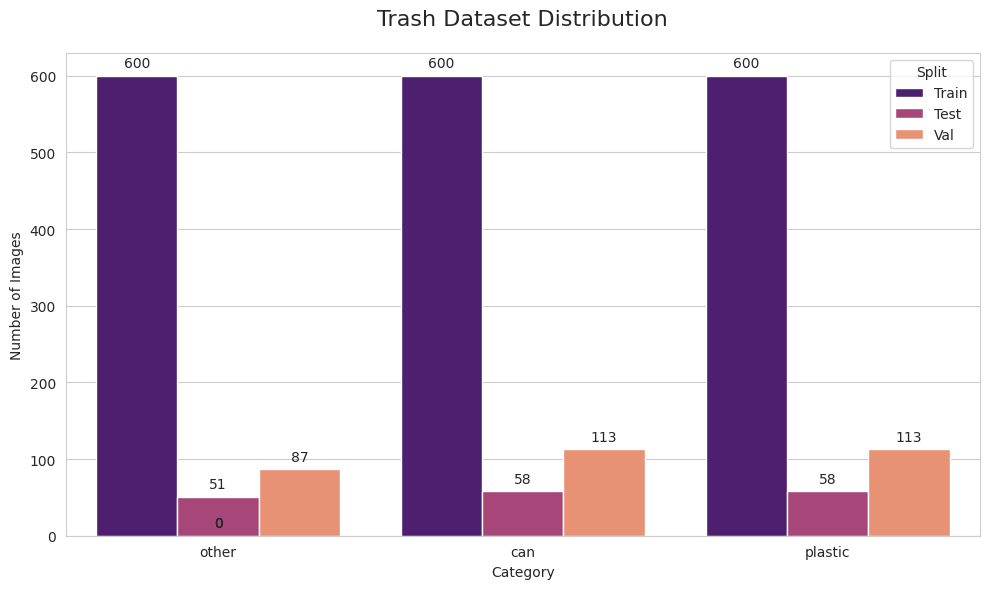

In [2]:
# path
root_dir = Path('/kaggle/input/3types-trash')

# map folder names to split labels
split_mapping = {
    'augmented_trainset': 'Train',
    'test': 'Test',
    'val': 'Val'
}

data = []

# iterate through the folders
for folder_name, label in split_mapping.items():
    split_path = root_dir / folder_name
    
    if split_path.exists():
        for class_dir in split_path.iterdir():
            if class_dir.is_dir():
                file_count = len(list(class_dir.glob('*')))
                data.append({
                    'Split': label,
                    'Class': class_dir.name,
                    'Count': file_count
                })

# dataFrame
df = pd.DataFrame(data)

# plot the distribution
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

ax = sns.barplot(data=df, x='Class', y='Count', hue='Split', palette='magma')

# adding labels for clarity
plt.title('Trash Dataset Distribution', fontsize=16, pad=20)
plt.ylabel('Number of Images')
plt.xlabel('Category')

# annotate the bars with the actual numbers
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

# The data is augmented outside already
    Rotation: 70% chance, ±10°
    Horizontal flip: 50%
    Vertical flip: 30%
    Random zoom: 50%, keeps 80% area
    Brightness: 50%, 70-130%
    Contrast: 50%, 80-120%

In [3]:
data_dir = Path('/kaggle/input/3types-trash/augmented_trainset')

image_paths = []
labels = []

valid_exts = {'.jpg', '.jpeg', '.png', '.bmp'}

class_dirs = [d for d in data_dir.iterdir() if d.is_dir()]

for class_dir in class_dirs:
    label = class_dir.name
    for img_path in class_dir.iterdir():
        if img_path.is_file() and img_path.suffix.lower() in valid_exts:
            image_paths.append(img_path)
            labels.append(label)

print(f"Total images found: {len(image_paths)}")

from collections import Counter
print("Class counts:", Counter(labels))

Total images found: 1800
Class counts: Counter({'other': 600, 'can': 600, 'plastic': 600})


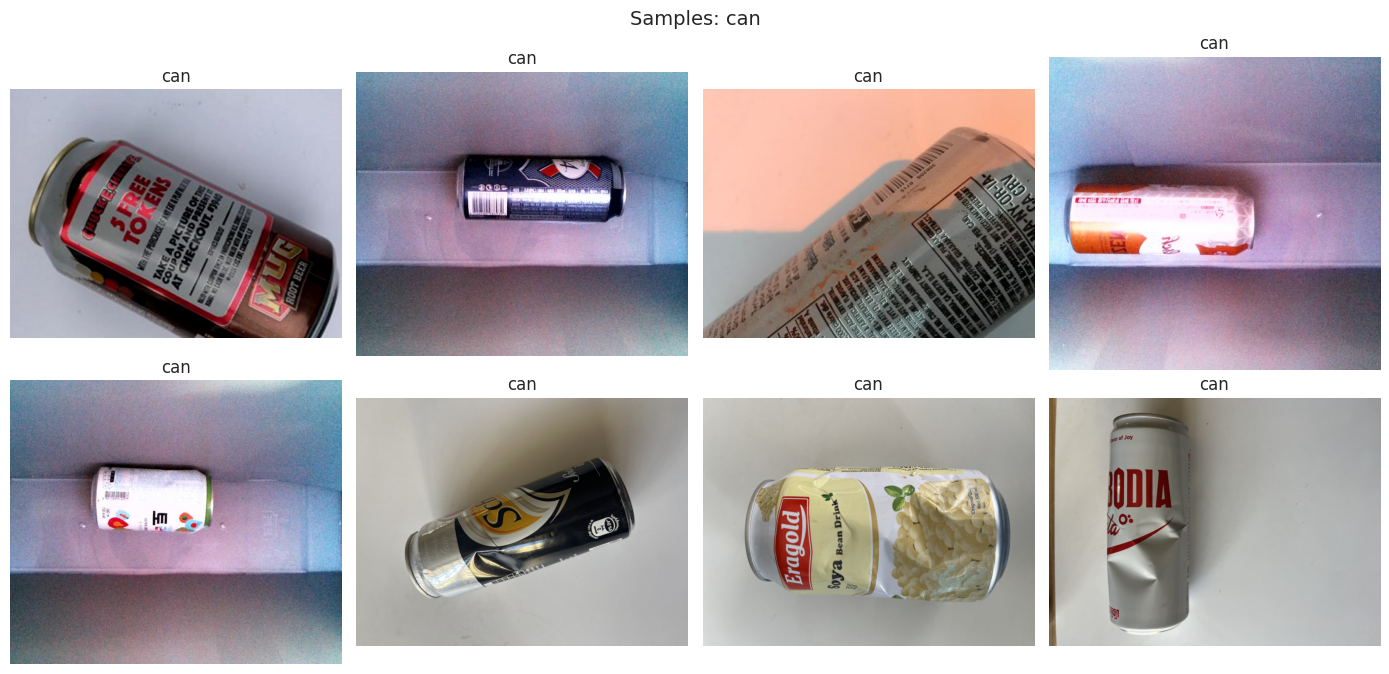

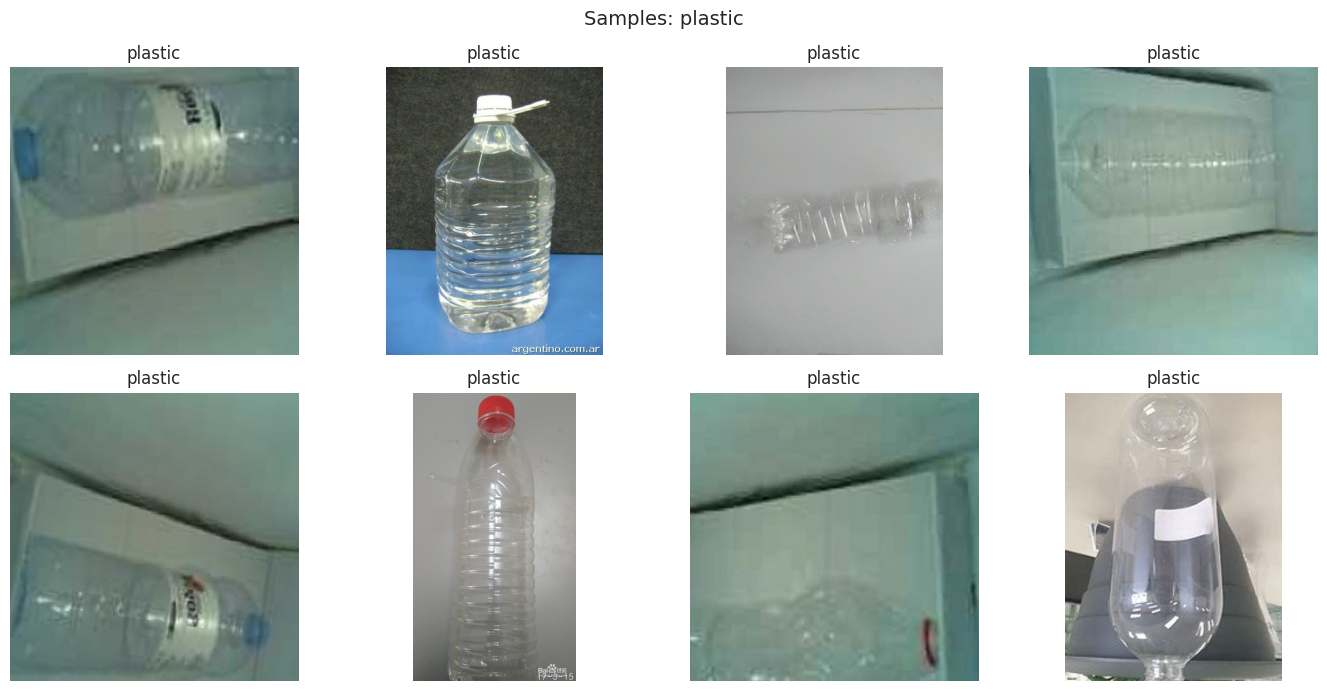

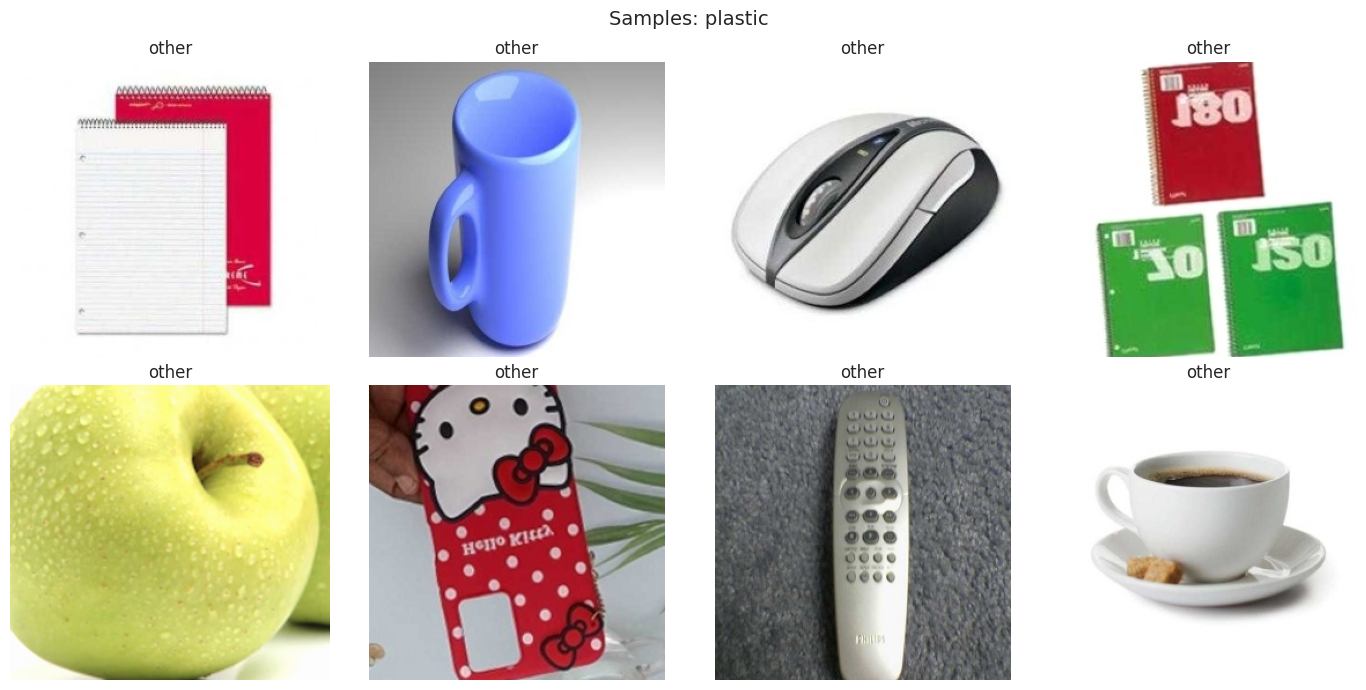

In [4]:
def show_grid(image_paths, title, n=8, cols=4):
    paths = random.sample(image_paths, min(n, len(image_paths)))
    rows = (len(paths) + cols - 1) // cols
    plt.figure(figsize=(3.5*cols, 3.5*rows))
    for i, p in enumerate(paths, 1):
        img = Image.open(p).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(p.parent.name)
    plt.suptitle(title, y=0.98, fontsize=14)
    plt.tight_layout()
    plt.show()

can_paths   = list(Path('/kaggle/input/3types-trash/augmented_trainset/can').glob('*.jpg'))
plastic_paths = list(Path('/kaggle/input/3types-trash/augmented_trainset/plastic').glob('*.jpg'))
other_paths = list(Path('/kaggle/input/3types-trash/augmented_trainset/other').glob('*.jpg'))

show_grid(can_paths,   title="Samples: can",   n=8, cols=4)
show_grid(plastic_paths, title="Samples: plastic", n=8, cols=4)
show_grid(other_paths, title="Samples: plastic", n=8, cols=4)

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
MY_CLASSES = ['can', 'other', 'plastic']

train_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/3types-trash/augmented_trainset",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_names=MY_CLASSES,
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/3types-trash/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_names=MY_CLASSES,
    shuffle=False
)

test_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/3types-trash/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_names=MY_CLASSES,
    shuffle=False
)

Found 1800 files belonging to 3 classes.


I0000 00:00:1769788932.192680      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 313 files belonging to 3 classes.
Found 167 files belonging to 3 classes.


In [7]:
# Build Model
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
# Stage freeze all layers
base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = keras.applications.mobilenet_v2.preprocess_input(inputs)

# training=False to keep BN in inference mode
x = base_model(x, training=False)         
x = layers.GlobalAveragePooling2D()(x)

# Apply 0.5 dropout
x = layers.Dropout(0.5)(x)     

# Change the output layer for 3 classes
outputs = layers.Dense(3, activation="softmax")(x) 
model = keras.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        )
    ]
)

Epoch 1/10


I0000 00:00:1769788942.441164      72 service.cc:152] XLA service 0x7f33ec10f950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769788942.441205      72 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769788943.897520      72 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1769788950.852303      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 624ms/step - accuracy: 0.3772 - loss: 1.4094 - val_accuracy: 0.6997 - val_loss: 0.7730
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.5809 - loss: 0.9511 - val_accuracy: 0.8562 - val_loss: 0.5271
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.7119 - loss: 0.7073 - val_accuracy: 0.9042 - val_loss: 0.3879
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.7894 - loss: 0.5409 - val_accuracy: 0.9297 - val_loss: 0.2999
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.8215 - loss: 0.4642 - val_accuracy: 0.9489 - val_loss: 0.2423
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.8640 - loss: 0.3673 - val_accuracy: 0.9521 - val_loss: 0.2030
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 222ms/step - accuracy: 0.8896 - loss: 0.3111 - val_accuracy: 0.9585 - val_loss: 0.1739
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.9050 - loss: 0.2720 - val_accuracy: 0.961

In [10]:
base_model.trainable = True 
total_layers = len(base_model.layers)
fine_tune_at = total_layers - 50  

# freeze the first part
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# UNFREEZE the last 50 layers
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Debug: check
trainable_in_base = sum(1 for l in base_model.layers if l.trainable)
frozen_in_base    = total_layers - trainable_in_base

print("Total layers in base_model:", total_layers)
print("Frozen layers in base_model:", frozen_in_base)
print("Trainable layers in base_model:", trainable_in_base)

print("Trainable outer layers in model:",
      sum(1 for l in model.layers if l.trainable))

Total layers in base_model: 154
Frozen layers in base_model: 104
Trainable layers in base_model: 50
Trainable outer layers in model: 5


In [11]:
# base_model.summary()

In [12]:
fine_tune_lr = 1e-5

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=7, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
        )
    ]
)

Epoch 1/10


2026-01-30 16:05:21.612631: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-30 16:05:21.809834: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


57/57 ━━━━━━━━━━━━━━━━━━━━ 55s 561ms/step - accuracy: 0.8297 - loss: 0.4489 - val_accuracy: 0.9776 - val_loss: 0.0845 - learning_rate: 1.0000e-05
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.9193 - loss: 0.2426 - val_accuracy: 0.9744 - val_loss: 0.0713 - learning_rate: 1.0000e-05
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.9519 - loss: 0.1495 - val_accuracy: 0.9744 - val_loss: 0.0633 - learning_rate: 1.0000e-05
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.9698 - loss: 0.1146 - val_accuracy: 0.9808 - val_loss: 0.0549 - learning_rate: 1.0000e-05
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.9765 - loss: 0.0907 - val_accuracy: 0.9840 - val_loss: 0.0483 - learning_rate: 1.0000e-05
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.9745 - loss: 0.0860 - val_accuracy: 0.9840 - val_loss: 0.0420 - learning_rate: 1.0000e-05
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - accuracy: 0.98

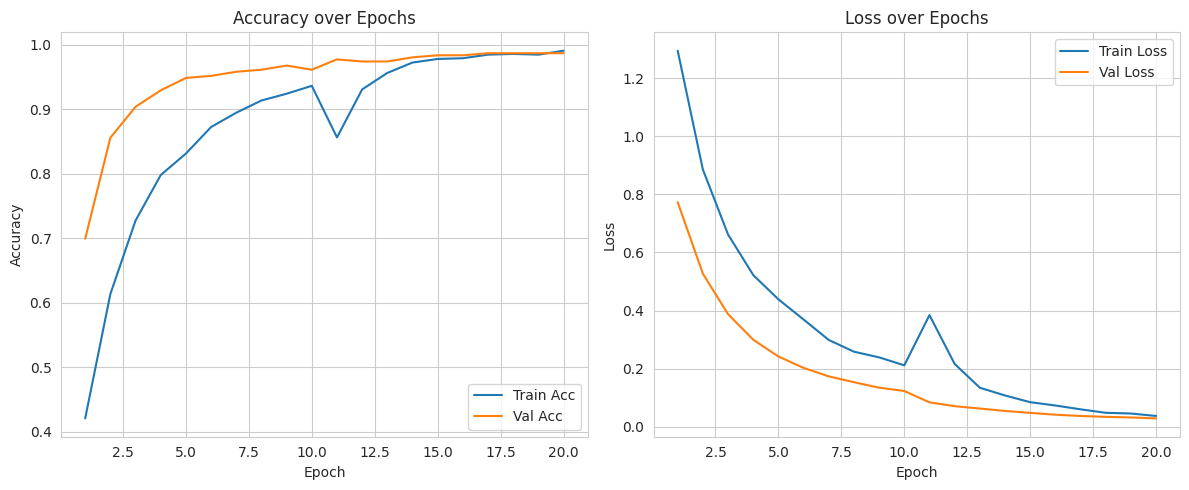

In [13]:
def combine_histories(h1, h2):
    combined = {}
    for k in h1.history.keys():
        combined[k] = h1.history[k] + h2.history.get(k, [])
    return combined

combined_history = combine_histories(history_stage1, history_stage2)

acc      = combined_history["accuracy"]
val_acc  = combined_history["val_accuracy"]
loss     = combined_history["loss"]
val_loss = combined_history["val_loss"]

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Train Acc")
plt.plot(epochs_range, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

         can       1.00      0.98      0.99        58
       other       0.98      1.00      0.99        51
     plastic       1.00      1.00      1.00        58

    accuracy                           0.99       167
   macro avg       0.99      0.99      0.99       167
weighted avg       0.99      0.99      0.99       167



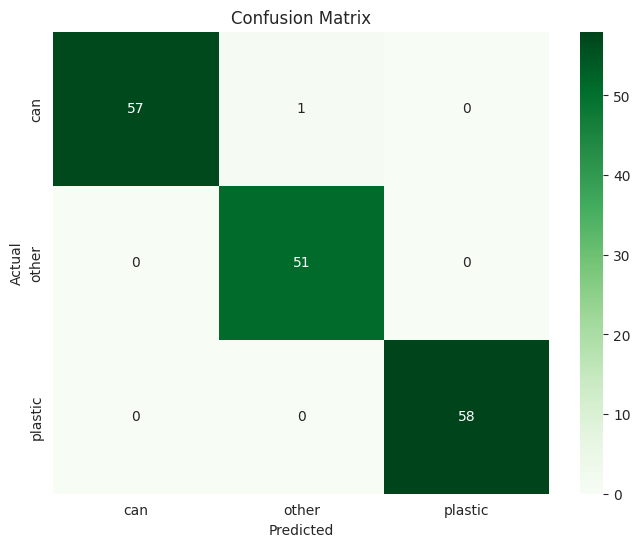

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(labels.numpy())

# Print the report
print(classification_report(y_true, y_pred, target_names=MY_CLASSES))

# Visualize the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=MY_CLASSES, yticklabels=MY_CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
model.save('ai-model2.keras')
model.save('ai-model2.h5')

# Convert the model to the tflite version

In [16]:
# float32 TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("ai-model-fp32-v2.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved ai-model-fp32-v2.tflite")

INFO:tensorflow:Assets written to: /tmp/tmpz_pdjm2o/assets


INFO:tensorflow:Assets written to: /tmp/tmpz_pdjm2o/assets


Saved artifact at '/tmp/tmpz_pdjm2o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139863950439056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863858030992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863858032336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863858031184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863858030608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863858030800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863858033296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863858034064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863858033680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863858022736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398638580

W0000 00:00:1769789307.925150      23 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1769789307.925195      23 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1769789308.087283      23 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
